In [1]:
using Printf
using Plots
using JuMP
using Cbc
using StatPlots
using DataFrames

## Funções auxiliares

In [2]:
function capacidade(X, G)
    capacidade = zeros(12)
    for i in 1:12
        for j in 1:length(G)
            if round(Int, X[j, i])==1
                capacidade[i]+=G[j]
            end
        end
    end
    c = sum(G)
    for i in 1:12
        capacidade[i] = c-capacidade[i]
    end
    return capacidade
end

capacidade (generic function with 1 method)

In [3]:
function cvar(θ, S, Dl)
    CVaR = zeros(12)
    VaR = ceil(Int, θ*S)
    for i in 1:12
        CVaR[i] = sum(sort(Dl[i, S-VaR+1:end]))/(VaR)
    end
    return CVaR
end

cvar (generic function with 1 method)

In [241]:
function dados_e_plot(G, schedule_matrix, d, title; alpha = 0.4, CVaR = zeros(1:12), legend = false)
    if length(size(G)) == 1
        nplants = length(G)
    else
        nplants = size(G)[1]
    end
    if length(size(d)) == 1
        nmonths = length(d)
    else
        nmonths = size(d)[1]
        Ns = size(d)[2]
    end
    schedule = DataFrame(months = collect(1:nmonths), plants_off = [[] for i in 1:nmonths],
        capacity_available = collect(zeros(1:nmonths)))
    for plant in 1:nplants
        for month in 1:nmonths
            if round(schedule_matrix[plant, month] - 0.1) == 1.0
                push!(schedule.plants_off[month], plant)
            else
                if length(size(G)) == 1
                    schedule.capacity_available[month] += G[plant] 
                else
                    schedule.capacity_available[month] += G[plant, month]
                end
            end
        end
    end
    plot1 = heatmap(schedule_matrix, colorbar = false, xlabel = "Meses", ylabel = "Usinas", xaxis = collect(1:nmonths),
        yaxis = collect(1:nplants), color = :PuRd, aspect_ratio = 1, title = "Heatmap das manutenções")
    #plot1 = bar(collect(1:nmonths), [size(plants_off) for plants_off in schedule.plants_off], xlabel = "Months", ylabel = "Number of plants off", aspect_ratio = 1, xaxis = collect(1:nmonths), yaxis = collect(1:nplants), color = :redsblues)
    if length(size(d)) == 1
        return schedule, plot1, groupedbar([schedule.capacity_available d], title = title, label = ["Capacidade", "Demanda"],
            colour = [:green :red], legend = legend, xaxis = collect(1:nmonths), xlabel = "Meses", ylabel = "Energia")
    else
        plot2 = groupedbar([schedule.capacity_available [maximum(d[month, :]) for month in 1:nmonths] [sum(d[month, :]) / Ns for month in 1:nmonths]],
            title = title, label = ["Capacidade", "Maior demanda", "Valor esp. da demanda"], colour = [:green :red :orange], legend = legend, xaxis = collect(1:nmonths), xlabel = "Mês", ylabel = "Energia", ylims = (0, 350))
        if sum(CVaR) != 0
            bar!(CVaR, alpha = alpha, colour = :lightblue, label = "CVaR")
        end
        return schedule, plot1, plot2
    end
end;

In [246]:
function comparison(d, G, dados1, schedule_matrix1, dados2, schedule_matrix2; xlabel1 = "dados1", xlabel2 = "dados2",
        title = "Comparação da capacidade disponível", legend1 = false)
    nplants = length(G)
    nmonths = size(dados1, 1)
    Ns = size(d)[2]
    plot1 = groupedbar([dados1.capacity_available dados2.capacity_available [maximum(d[month, :]) for month in 1:nmonths] [sum(d[month, :]) / Ns for month in 1:nmonths]],
        label = [xlabel1; xlabel2; ["Maior demanda"]; ["Valor esp. da demanda"]], colour = [:green :blue :red :orange],
        xlabel = "Mês", ylabel = "Capacidade", xaxis = collect(1:nmonths), title = title, legend = legend1, ylims = (0, 350))
    plot2 = bar(collect(1:nmonths), [size(dados1.plants_off[month])[1] for month in 1:nmonths], xaxis = collect(1:nmonths),
        ylabel = "Nº de usinas desligadas", xlabel = xlabel1, legend = false)
    plot3 = bar(collect(1:nmonths), [size(dados2.plants_off[month])[1] for month in 1:nmonths], xaxis = collect(1:nmonths),
        xlabel = xlabel2, legend = false)
    plot4 = heatmap(schedule_matrix1, colorbar = false, xlabel = "Meses", ylabel = "Usinas", xaxis = collect(1:nmonths),
        yaxis = collect(1:nplants), color = :PuRd, aspect_ratio = 1)
    plot5 = heatmap(schedule_matrix2, colorbar = false, xlabel = "Meses", xaxis = collect(1:nmonths),
        yaxis = collect(1:nplants), color = :PuRd, aspect_ratio = 1)    
    plot6 = plot(plot2, plot3, plot4, plot5, layout = (2, 2), link = :y)
    return plot1, plot6
end;

# Problema de agendamento de manutenção

In [247]:
# Capacidade de cada usina
G = [10,5,20,18,23,32,7,12,10,20,17,32,12,13,17];
# Demanda de cada mês
D = [238,220,187,175,135,127,144,165,193,205,213,233];
#θ piores casos
θ = 0.2
#Número de cenários
Ns = 10;

## 1) Problema inicial

<center>$min$ $\alpha$</center>

<center>$s.a.$ $\alpha$ $\geq$ $\sum_i Gdisp_i^t-D_t$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

In [248]:
function modelo1(G, d)
    T = 12;
    N = length(G);
    m = Model(solver = CbcSolver());
    @variable(m, x[1:N,1:T], Bin);
    @variable(m, α);
    @objective(m, Min, α);
    @constraintref myCons[1:N]
    for i = 1:N
      myCons[i] = @constraint(m, sum(x[i,j] for j=1:T) >= 1);
    end
    @constraintref myCons1[1:T]
    for j = 1:T
      myCons1[j] = @constraint(m, α >= sum(G[i]*(1-x[i,j]) for i=1:N) - d[j])
    end
    @constraintref myCons2[1:T]
    for j = 1:T
      myCons2[j] = @constraint(m, sum(G[i]*(1-x[i,j]) for i=1:N) >= d[j])
    end
    @time status = solve(m)
    return m, getvalue(x)
end

modelo1 (generic function with 1 method)

In [249]:
m1, X1 = modelo1(G, D);

  0.278956 seconds (66 allocations: 64.070 KiB)


In [250]:
capacidade1 = capacidade(X1, G)
aux = hcat(D, capacidade1);

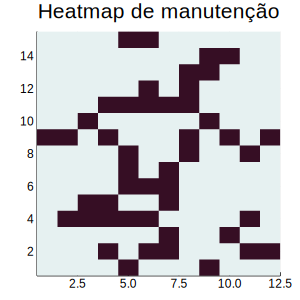

In [251]:
heatmap(X1, color = :dense, size=(300,300), legend=false, title="Heatmap de manutenção")

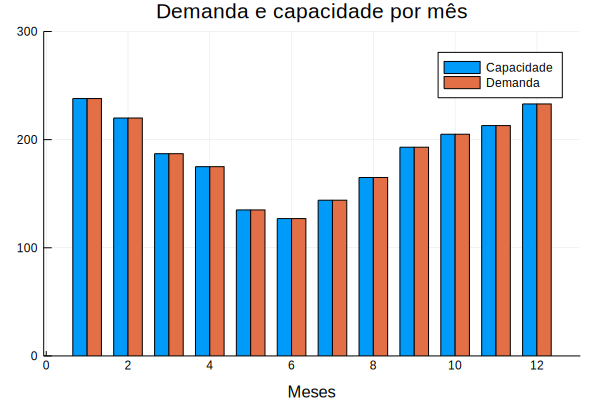

In [252]:
ctg = repeat(["Demanda", "Capacidade"], inner = 12)
groupedbar(aux, group = ctg, xlabel = "Meses", title = "Demanda e capacidade por mês", 
    bar_position = :dodge, bar_width=0.7, ylims = (0,300))

## 2) Cenários de renováveis e demanda líquida com otimização de valor esperado

<center>$min$ $\sum_s \alpha_t^s\cdot \frac{1}{N_s}$</center>

<center>$s.a.$ $\alpha_t^s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

In [253]:
#Quantidade de cenários
S = 10;
#Capacidade de renováveis
R = rand(1:100,12, S);
Dl = D;
for i in 2:S
    Dl = hcat(Dl, D)
end
#Demanda líquida
Dl = Dl-R;

In [254]:
function modelo2(G, Dl)
    T = 12;
    N = length(G);
    S = size(Dl)[2];
    m = Model(solver = CbcSolver());
    @variable(m, x[1:N,1:T], Bin);
    @variable(m, α[1:S])
    @constraintref myCons[1:N]
    for i = 1:N
      myCons[i] = @constraint(m, sum(x[i,j] for j=1:T) >= 1);
    end
    @constraintref myCons1[1:T,1:S]
    for j = 1:T
        for k = 1:S
            myCons1[j,k] = @constraint(m, α[k] >= sum(G[i]*(1-x[i,j]) for i=1:N) - Dl[j,k])
        end
    end
    @constraintref myCons2[1:T,1:S]
    for j = 1:T
        for k = 1:S
            myCons2[j,k] = @constraint(m, sum(G[i]*(1-x[i,j]) for i=1:N) >= Dl[j,k])
        end
    end
    @objective(m, Min, sum(α[k] for k=1:S)/S);
    @time status = solve(m)
    return m, getvalue(x)
end

modelo2 (generic function with 1 method)

In [255]:
m2, X2 = modelo2(G, Dl);

  0.098715 seconds (71 allocations: 280.023 KiB)


In [256]:
capacidade2 = capacidade(X2, G)
valor_esperado = [sum(Dl[i,:])/S for i in 1:12]
maior_demanda =[sort(Dl[i,:])[end] for i in 1:12]
aux = hcat(valor_esperado, maior_demanda, capacidade2);

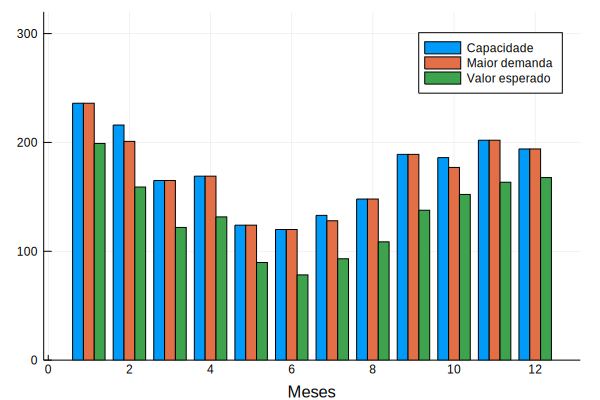

In [257]:
ctg = repeat(["Valor esperado", "Maior demanda", "Capacidade"], inner = 12)
groupedbar(aux, group = ctg, xlabel = "Meses", bar_position = :dodge, bar_width=0.8, ylims = (0,320))

## 3) CVaR determinístico nas restrições

<center>$min$ $\alpha$</center>

<center>$s.a.$ $\alpha$ $\geq$ $\sum_i Gdisp_i^t-CVaR_\theta(Dliq_t^s)$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

In [275]:
G6_1 = G
θ6_1 = θ
Ns6_1 = Ns
d6_1 = Dl
nCVaR6_1 = Int(floor(θ6_1 * Ns6_1))
nplants6_1 = length(G6_1)
nmonths6_1 = size(d6_1)[1];

In [276]:
CVaR_d6_1 = zeros(nmonths6_1)
for month in 1:nmonths6_1
    CVaR_d6_1[month] = sum(sort(d6_1[month, :])[(Ns6_1 - nCVaR6_1 + 1):Ns6_1]) / nCVaR6_1
end

In [277]:
m6_1 = Model(solver = CbcSolver())

@variable(m6_1, x[1:nplants6_1, 1:nmonths6_1], Bin)
@variable(m6_1, α)

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6_1]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6_1, sum(x[plant, 1:nmonths6_1]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6_1, 1:Ns6_1]
for month in 1:nmonths6_1
    for scenario in 1:Ns6_1
        constraints2[month, scenario] = @constraint(m6_1, sum(G6_1 .* (1 .- x[1:nplants6_1, month])) >= d6_1[month, scenario])
    end
end

@constraintref constraints3[1:nmonths6_1]
for month in eachindex(constraints3)
    constraints3[month] = @constraint(m6_1, α >= sum(G6_1 .* (1 .- x[1:nplants6_1, month])) - CVaR_d6_1[month])
end

@objective(m6_1, Min, α);

In [278]:
solve(m6_1)
schedule_matrix6_1 = getvalue(x);

In [279]:
dados6_1, plot1_6_1, plot2_6_1 = dados_e_plot(G6_1, schedule_matrix6_1, d6_1, "CVaR determinístico nas restrições", CVaR = CVaR_d6_1, legend = true)
dados6_1

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[8],236.0
2,2,"[1, 9, 13, 14]",203.0
3,3,"[1, 4, 5, 10, 13]",165.0
4,4,"[4, 5, 7, 8, 11]",171.0
5,5,"[1, 2, 4, 7, 8, 9, 11, 13, 14, 15]",127.0
6,6,"[4, 6, 11, 12, 13, 15]",120.0
7,7,"[1, 3, 4, 5, 12, 13]",133.0
8,8,"[5, 11, 12, 13, 14]",151.0
9,9,"[4, 8, 11, 13]",189.0


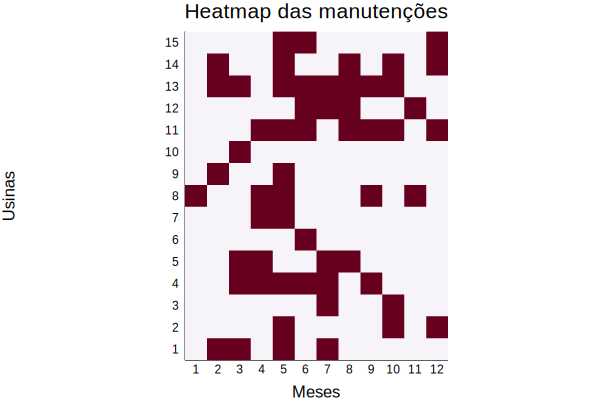

In [280]:
plot1_6_1

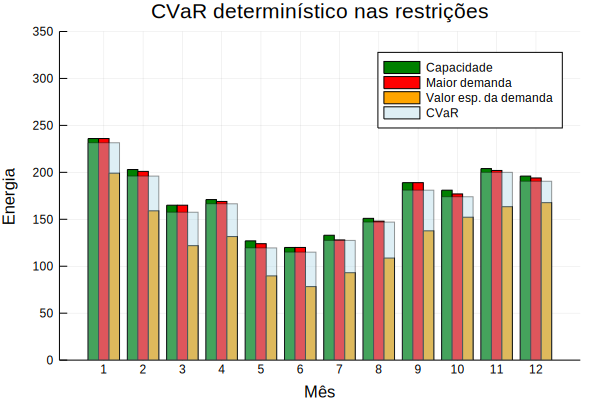

In [281]:
plot2_6_1

## 4) CVaR como problema de otimização na função objetivo

<center>$min$ $CVaR_\theta(\alpha)$</center>

<center>$s.a.$ $\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

Ou seja:

<center>$min$ $C$</center>

<center>$s.a.$ $\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

<center>$C = z - \sum_s p_s \frac{\delta_s}{1-\theta}$</center>

<center>$\delta_s \leq z-\alpha_s$</center>

<center>$\delta_s \leq 0$</center>

In [282]:
G6_2 = G
d6_2 = Dl
θ6_2 = θ

Ns6_2 = Ns
nplants6_2 = length(G6_2)
nmonths6_2 = size(d6_2)[1];

In [283]:
m6_2 = Model(solver = CbcSolver())

@variable(m6_2, x[1:nplants6_2, 1:nmonths6_2], Bin)
@variable(m6_2, α[1:Ns6_2])
@variable(m6_2, z)
@variable(m6_2, δ[1:Ns6_2])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6_2]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6_2, sum(x[plant, 1:nmonths6_2]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6_2, 1:Ns6_2]
for month in 1:nmonths6_2
    for scenario in 1:Ns6_2
        constraints2[month, scenario] = @constraint(m6_2, sum(G6_2 .* (1 .- x[1:nplants6_2, month])) >= d6_2[month, scenario])
    end
end

@constraintref constraints3[1:nmonths6_2, 1:Ns6_2]
for month in 1:nmonths6_2
    for scenario in 1:Ns6_2
        constraints3[month, scenario] = @constraint(m6_2, α[scenario] >= sum(G6_2 .* (1 .- x[1:nplants6_2, month])) - d6_2[month, scenario])
    end
end

@constraintref constraints4[1:Ns6_2]
for scenario in eachindex(constraints4)
    constraints4[scenario] = @constraint(m6_2, δ[scenario] <= z - α[scenario])
end

@constraintref constraints5[1:Ns6_2]
for scenario in eachindex(constraints5)
    constraints5[scenario] = @constraint(m6_2, δ[scenario] <= 0)
end

@objective(m6_2, Min, z - sum(1 / Ns6_2 * δ[scenario] / (1 - θ6_2) for scenario in 1:Ns6_2));

In [284]:
solve(m6_2)
schedule_matrix6_2 = getvalue(x);

In [288]:
dados6_2, plot1_6_2, plot2_6_2 = dados_e_plot(G6_2, schedule_matrix6_2, d6_2,
    "CVaR como problema de otimização na função objetivo", legend = true)
dados6_2

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[8],236.0
2,2,"[1, 9, 13]",216.0
3,3,"[1, 2, 4, 5, 7, 10]",165.0
4,4,"[1, 5, 8, 11, 15]",169.0
5,5,"[1, 2, 3, 4, 7, 8, 9, 11, 13, 14]",124.0
6,6,"[3, 5, 6, 7, 8, 11, 15]",120.0
7,7,"[1, 3, 4, 5, 12, 13]",133.0
8,8,"[3, 5, 12, 13, 14]",148.0
9,9,"[1, 2, 8, 10, 13]",189.0


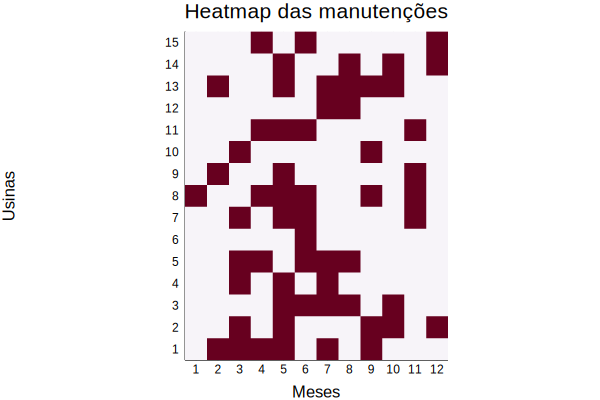

In [289]:
plot1_6_2

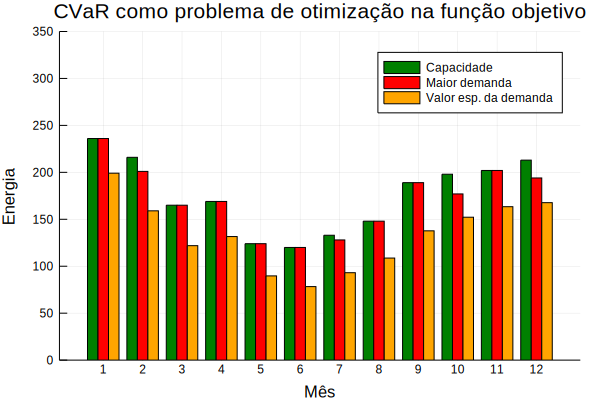

In [290]:
plot2_6_2

## Comparação entre o CVaR na função objetivo e na restrição

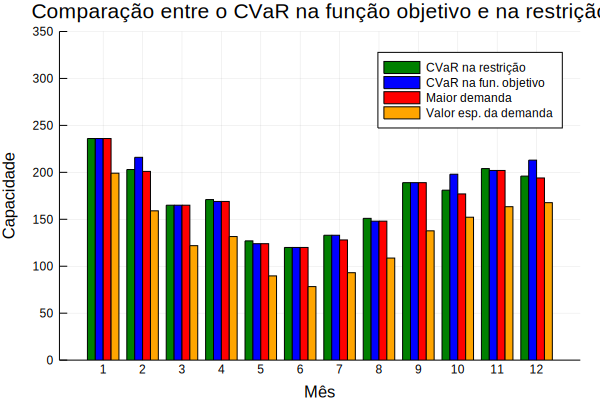

In [291]:
comp6_1and6_2 = comparison(Dl, G, dados6_1, schedule_matrix6_1, dados6_2, schedule_matrix6_2, xlabel1 = "CVaR na restrição", xlabel2 = "CVaR na fun. objetivo", title = "Comparação entre o CVaR na função objetivo e na restrição", legend1 = true)
comp6_1and6_2[1]

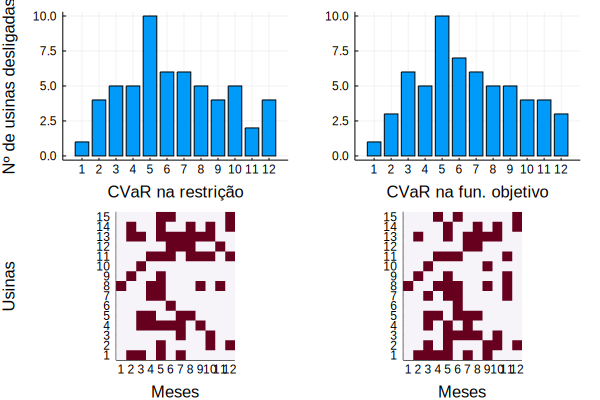

In [292]:
comp6_1and6_2[2]

## Comparação entre o CVaR e o valor esperado na função objetivo

In [294]:
dados2 = dados_e_plot(G, X2, Dl, "Valor esperado na função objetivo")[1];

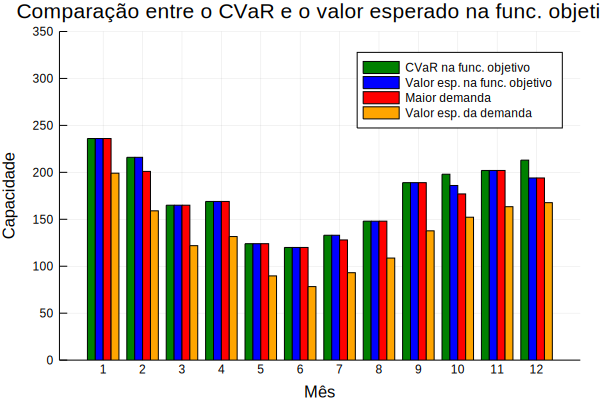

In [295]:
comp6_2and2 = comparison(Dl, G, dados6_2, schedule_matrix6_2, dados2, X2; xlabel1 = "CVaR na func. objetivo",
    xlabel2 = "Valor esp. na func. objetivo", title = "Comparação entre o CVaR e o valor esperado na func. objetivo",
    legend1 = true)
comp6_2and2[1]

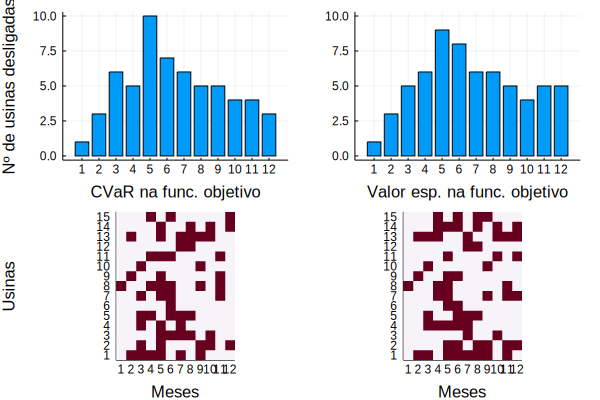

In [296]:
comp6_2and2[2]

## 5) Combinação convexa de Valor esperado e CVaR

<center>$min$ $\lambda \cdot CVaR_\theta(\alpha) + (1-\lambda)\cdot \sum_s \alpha_s\cdot\frac{1}{N_s}$</center>

<center>$s.a.$ $\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

Ou seja:

<center>$min$ $\lambda \cdot C + (1-\lambda)\cdot \sum_s \alpha_s\cdot\frac{1}{N_s}$</center>

<center>$s.a.$ $\alpha_s$ $\geq$ $\sum_i Gdisp_i^t-Dliq_t^s$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i Gdisp_i^t \geq D_t$ $\forall t$</center>

<center>$Gdisp_i^t = (1-x_i^t)G^i$ $\forall i, t$</center>

<center>$C = z - \sum_s p_s \frac{\delta_s}{1-\theta}$</center>

<center>$\delta_s \leq z-\alpha_s$</center>

<center>$\delta_s \leq 0$</center>

In [297]:
G6_3 = G
d6_3 = Dl
θ6_3 = θ
λ6_3 = 0.5

Ns6_3 = Ns
nplants6_3 = length(G6_3)
nmonths6_3 = size(d6_3)[1];

In [298]:
m6_3 = Model(solver = CbcSolver())

@variable(m6_3, x[1:nplants6_3, 1:nmonths6_3], Bin)
@variable(m6_3, α[1:Ns6_3])
@variable(m6_3, z)
@variable(m6_3, δ[1:Ns6_3])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6_3]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6_3, sum(x[plant, 1:nmonths6_3]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6_3, 1:Ns6_3]
for month in 1:nmonths6_3
    for scenario in 1:Ns6_3
        constraints2[month, scenario] = @constraint(m6_3, sum(G6_3 .* (1 .- x[1:nplants6_3, month])) >= d6_3[month, scenario])
    end
end

@constraintref constraints3[1:nmonths6_3, 1:Ns6_3]
for month in 1:nmonths6_3
    for scenario in 1:Ns6_3
        constraints3[month, scenario] = @constraint(m6_3, α[scenario] >= sum(G6_3 .* (1 .- x[1:nplants6_3, month])) - d6_3[month, scenario])
    end
end

@constraintref constraints4[1:Ns6_3]
for scenario in eachindex(constraints4)
    constraints4[scenario] = @constraint(m6_3, δ[scenario] <= z - α[scenario])
end

@constraintref constraints5[1:Ns6_3]
for scenario in eachindex(constraints5)
    constraints5[scenario] = @constraint(m6_3, δ[scenario] <= 0)
end

@expression(m6_3, CVaR, z - sum(1 / Ns6_3 * δ[scenario] / (1 - θ6_3) for scenario in 1:Ns6_3))
@expression(m6_3, Eα, sum(α) / Ns6_3)

@objective(m6_3, Min, λ6_3 * CVaR + (1 - λ6_3) * Eα);

In [299]:
solve(m6_3)
schedule_matrix6_3 = getvalue(x);

In [300]:
dados6_3, plot1_6_3, plot2_6_3 = dados_e_plot(G6_3, schedule_matrix6_3, d6_3, "Combinação convexa entre CVaR e valor esperado",
    legend = true)
dados6_3

,months,plants_off,capacity_available
,Int64,Array…,Float64
1,1,[8],236.0
2,2,"[1, 9, 13]",216.0
3,3,"[2, 4, 5, 7, 9, 10]",165.0
4,4,"[1, 2, 4, 5, 9, 14]",169.0
5,5,"[1, 2, 3, 4, 7, 8, 9, 11, 13, 14]",124.0
6,6,"[2, 3, 4, 5, 6, 14, 15]",120.0
7,7,"[1, 3, 4, 5, 12, 13]",133.0
8,8,"[1, 2, 5, 6, 14, 15]",148.0
9,9,"[1, 2, 8, 10, 13]",189.0


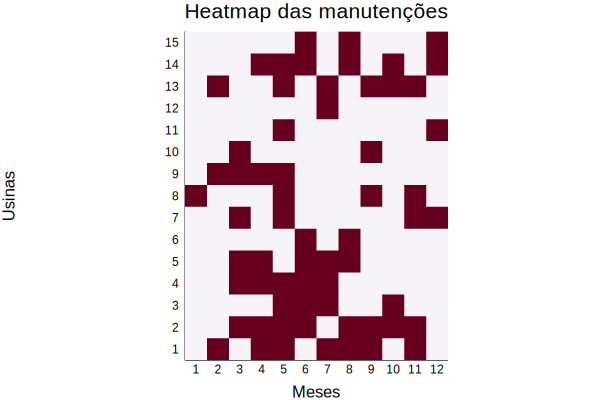

In [301]:
plot1_6_3

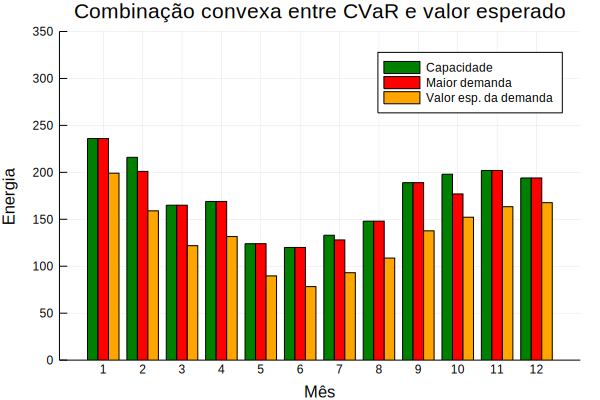

In [302]:
plot2_6_3

## 6) Minimizar custo total

<center>$min$ $\sum_t \alpha^t + \sum_{i,t}c_i\cdot g_i^t + \sum_{i,t} k_i \cdot x_i^t$</center>

<center>$s.a.$ $\alpha^t$ $\geq$ $\sum_i g_i^t-D_t$   $\forall t$</center>

<center>$\sum_t x_i^t \geq 1$ $\forall t$</center>

<center>$\sum_i g_i^t \geq D_t$ $\forall t$</center>

<center>$g_i^t \leq G_i\cdot (1-x_i^t)$</center>

In [303]:
# Custo de geração
c = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15];
# Custo de manutenção
k = [1,1,1,1,1,1,1,1,1,2,2,2,2,1,1];

In [304]:
function modelo6(G, D, c, k)
    T = 12;
    N = length(G);
    m = Model(solver = CbcSolver());
    @variable(m, x[1:N,1:T], Bin);
    @variable(m, α[1:T])
    @variable(m, g[1:N,1:T] >= 0)
    @constraintref myCons[1:N]
    for i = 1:N
      myCons[i] = @constraint(m, sum(x[i,j] for j=1:T) >= 1);
    end
    @constraintref myCons1[1:T]
    for j = 1:T
        myCons1[j] = @constraint(m, α[j] >= sum(g[i,j] for i=1:N) - D[j])
    end
    @constraintref myCons2[1:T]
    for j = 1:T
        myCons2[j] = @constraint(m, sum(g[i,j] for i=1:N) >= D[j])
    end
    @constraintref myCons3[1:N,1:T]
    for i = 1:N
        for j = 1:T
            myCons3[i,j] = @constraint(m, g[i,j]<=G[i]*(1-x[i,j]))
        end
    end
    @objective(m, Min, sum(α[j] for j=1:T)+sum(sum(c[i]*g[i,j] for i=1:N) for j=1:T)+sum(sum(k[i]*x[i,j] 
                for j=1:T) for i=1:N));
    @time status = solve(m)
    αa = getvalue(α)
    ga = getvalue(g)
    xa = getvalue(x)
    custo = [αa[j]+sum(c[i]*ga[i,j] for i=1:N)+sum(k[i]*xa[i,j] for i=1:N) for j = 1:T]
    return m, ga, xa, custo
end

modelo6 (generic function with 1 method)

In [305]:
m6, g6, X6, custo = modelo6(G,D,c,k);

  0.133298 seconds (66 allocations: 111.758 KiB)


In [306]:
cap = convert(DataFrame, g6)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0,10.0,10.0,10.0
2,5.0,5.0,5.0,5.0,5.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0
3,20.0,20.0,20.0,20.0,20.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0
4,18.0,18.0,18.0,18.0,18.0,0.0,18.0,18.0,18.0,18.0,18.0,18.0
5,23.0,23.0,23.0,23.0,23.0,23.0,0.0,23.0,23.0,23.0,23.0,23.0
6,32.0,32.0,32.0,32.0,0.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0
7,7.0,7.0,7.0,7.0,7.0,7.0,0.0,7.0,7.0,7.0,7.0,7.0
8,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,0.0,12.0,12.0,12.0
9,10.0,10.0,10.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


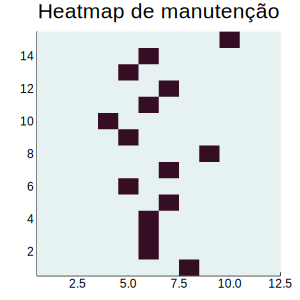

In [307]:
heatmap(X6, color = :dense, size=(300,300), legend=false, title="Heatmap de manutenção")

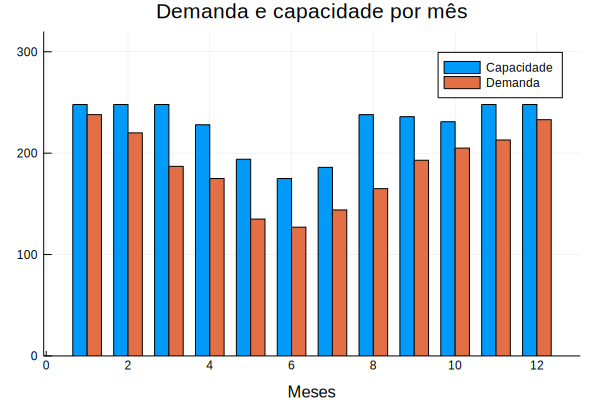

In [308]:
capacidade6 = capacidade(X6, G)
aux = hcat(D, capacidade6)
ctg = repeat(["Demanda", "Capacidade"], inner = 12)
groupedbar(aux, group = ctg, xlabel = "Meses", title = "Demanda e capacidade por mês", 
    bar_position = :dodge, bar_width=0.7, ylims = (0,320))

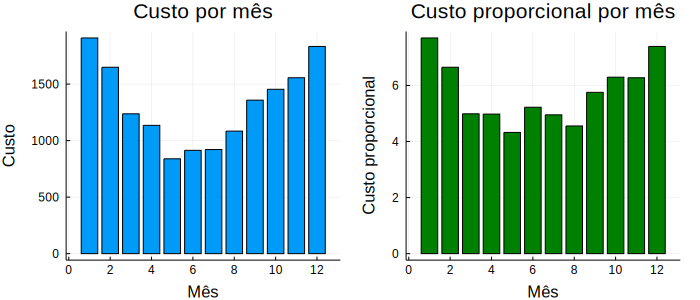

In [309]:
custo_mensal = bar(custo, legend=false, title = "Custo por mês", xlabel="Mês", ylabel="Custo")
cp = [custo[i]/capacidade6[i] for i in 1:12]
custo_proporcional = bar(cp, legend=false, title = "Custo proporcional por mês", xlabel="Mês", ylabel="Custo proporcional",
    color="green")
plot(custo_mensal, custo_proporcional, size=(700, 300))